### Project Plan

The purpose of this project is to create a recommendation system that produces movie recommendations for watchers based on their previous ratings. To clarify further, a movie water 'user' will input a set of ratings on movies that they have seen, and using these ratings as well as ratings inputted by other users, we can create implied ratings for the movies the user has not seen, and then take those top ratings to produce recommendations for the user. There are two typical approaches to creating such ratings:

*Collaborative filtering*: A system to produce ratings based solely on ratings and using no other endogenous data about either the users or the films. This system makes use of similarity algorithms (more on those below) that either compare users to other users or compare movies to other movies.

*Content hybrid*: A system to create recommendations based on endogenous features about the product being recommended. In this context, a hybrid rating system would use endogenous data about the movies (i.e. genre, cast, runtime) to find similar movies to recommend to a user.

The surprise package in python allows for the easy implementation of a collaborative filtering recommendation system.

Given the capabilities in the surprise package for creating a recommendation system, the code is split into the following portions:

1. Import data and transform into usable form compatible with surprise package
2. Use GridSearchCV on the training data to fit various models using collaborative filtering
3. Introduce content filtering to see if it improves results

In [318]:
# import general packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import surprise packages
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split,GridSearchCV,cross_validate
from surprise.prediction_algorithms import knns,SVD,SVDpp,NMF,SlopeOne,CoClustering
from surprise.similarities import cosine, msd, pearson
from surprise import accuracy




In [281]:
from sklearn.metrics.pairwise import cosine_similarity

In [214]:
# import data
df_movies = pd.read_csv('./data/movies.csv')
df_ratings = pd.read_csv('./data/ratings.csv')

In [215]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [216]:
# check for missing values
print(df_movies.isna().sum())

movieId    0
title      0
genres     0
dtype: int64


In [217]:
# check for duplicate movies
print(df_movies.duplicated().sum())

0


In [218]:
# get number of movies
df_movies.shape[0]

9742

In [310]:
df_ratings.groupby('userId').mean()

,movieId,rating
userId,,
1,1854.603448,4.366379
2,70350.275862,3.948276
3,7058.384615,2.435897
4,1982.129630,3.555556
5,343.840909,3.636364
...,...,...
606,9692.197309,3.657399
607,1860.636364,3.786096
608,4502.605295,3.134176


In [220]:
# drop timestamp column
df_ratings = df_ratings.drop('timestamp',axis=1)
df_ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [221]:
# check for missing values
df_ratings.isna().sum()

userId     0
movieId    0
rating     0
dtype: int64

In [222]:
# check for duplicates
df_ratings.duplicated().sum()

0

In [223]:
# get number of users
len(list(set(df_ratings['userId'])))

610

Now that we have examined the data and made sure it is in a usable form, we can fit it to surprise functions and convert it into a form usable by the package.

In [224]:
reader = Reader()
data = Dataset.load_from_df(df_ratings,reader)

In [28]:
# split data into training and test sets
train, test = train_test_split(data,test_size=0.4)

In [29]:
# look at size of data split
print('Number of users: ', train.n_users, '\n')
print('Number of items: ', train.n_items)

Number of users:  610 

Number of items:  8069


As expected from above, there are 610 users in the dataset, all of which are included in the training set. It is important to note that there is a much larger number of movies than number of users, which is expected - a single user can rate many movies. From the perspective of making recommendations, it will be much faster for the optimizer to use similarities between users than movies, so for the first part of the project, that is what the focus will be.

Another point of information is that the training set is comprised of all users, not a subset of them - rather, the training part of the dataset is a subset of all user and rating pairings. The test set, or holdout set, is new movies for which we know a specific user's rating, but which we will use the model to predict for a comparison.

Given that we are going to focus on similarities between users to start, there are several ways we can approach this. The surprise package offers four kinds of similarity algorithms that we can use from:

1. cosine similarity
2. mean-square difference similarity
3. pearson similarity
4. pearson_baseline (penalized pearson) similarity

Additionally, there are numerous approaches to the actual prediction algorithm. The most basic are SVD and KNN, though we will examine the broad set of algortithms in this notebook.

Additionally, we need to consider the choice of error metric. The surprise function offers multiple options, but the two most commonly chosen are MAE (mean absolute error) and RMSE (root mean squared error). Both are useful in that the error is interpretable as a function of the result unit, i.e. an RMSE or MAE of 1 would both represent the average error in the rating being off by a value of 1 (out of 10). The difference is that MAE treats each deviation the same, whereas RMSE penalizes larger deviations from the true value. The choice of error in model selection thus relies on our own interpretation of model value - is the bigger risk the recommendation of a movie very far off from the user's preferences, or movies that are perhaps just so-so but maybe more frequent? We can look at both in the code below, but most likely the RMSE will be used to deliver the final model. 

## MODEL SELECTION

In [111]:
# create a new dictionary to store results - will allow storage of best model params and scores for each
dict_results = {}
np.random.seed(100)

In [81]:
# initialize grid-search params for KNN basic
knn_basic = knns.KNNBasic(sim_options=sim_cosine)
cv_knn_basic = cross_validate(knn_basic, data, n_jobs=-1)

In [108]:
gs_params_knnBasic = {'k':[10,25,40,55,70],
                      'min_k':[1,5,10],
                      'sim_options': {
                          'name': ['msd','cosine','pearson'],
                          'user_based': [True]},
                      'bsl_options': {
                          'name': ['als','sgd']}}

gs_knnBasic = GridSearchCV(knns.KNNBasic,param_grid=gs_params_knnBasic,n_jobs=-1,joblib_verbose=0)
gs_knnBasic.fit(data)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine si

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson si

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine si

In [109]:
gs_knnBasic.best_score

{'rmse': 0.9393424305480031, 'mae': 0.7164070141984459}

In [110]:
gs_knnBasic.best_params

{'rmse': {'k': 10,
  'min_k': 5,
  'sim_options': {'name': 'msd', 'user_based': True},
  'bsl_options': {'name': 'als'}},
 'mae': {'k': 10,
  'min_k': 1,
  'sim_options': {'name': 'msd', 'user_based': True},
  'bsl_options': {'name': 'als'}}}

In [112]:
# using past CV results, run another iteration
gs_params_knnBasic_2 = {'k':[5,10,15,20],
                        'min_k':[2,5,8],
                        'sim_options': {
                            'name': ['msd','cosine','pearson'],
                            'user_based': [True]},
                        'bsl_options': {
                            'name': ['als','sgd']}}

gs_knnBasic_2 = GridSearchCV(knns.KNNBasic,param_grid=gs_params_knnBasic_2,n_jobs=-1,joblib_verbose=0)
gs_knnBasic_2.fit(data)

In [113]:
gs_knnBasic_2.best_score    

{'rmse': 0.9331655250878207, 'mae': 0.7136247714942427}

In [114]:
gs_knnBasic_2.best_params

{'rmse': {'k': 15,
  'min_k': 2,
  'sim_options': {'name': 'msd', 'user_based': True},
  'bsl_options': {'name': 'als'}},
 'mae': {'k': 15,
  'min_k': 2,
  'sim_options': {'name': 'msd', 'user_based': True},
  'bsl_options': {'name': 'als'}}}

In [115]:
# using past CV results, run another iteration
gs_params_knnBasic_3 = {'k':[10,15,20],
                        'min_k':[1,2,3,5],
                        'sim_options': {
                            'name': ['msd','cosine','pearson'],
                            'user_based': [True]},
                        'bsl_options': {
                            'name': ['als','sgd']}}

gs_knnBasic_3 = GridSearchCV(knns.KNNBasic,param_grid=gs_params_knnBasic_3,n_jobs=-1,joblib_verbose=0)
gs_knnBasic_3.fit(data)

In [116]:
gs_knnBasic_3.best_score

{'rmse': 0.9312683813898914, 'mae': 0.7110237717907308}

In [118]:
gs_knnBasic_3.best_params

{'rmse': {'k': 15,
  'min_k': 2,
  'sim_options': {'name': 'msd', 'user_based': True},
  'bsl_options': {'name': 'als'}},
 'mae': {'k': 10,
  'min_k': 2,
  'sim_options': {'name': 'msd', 'user_based': True},
  'bsl_options': {'name': 'als'}}}

In [ ]:
# add results to dict
dict_results['knnBasic'] = {'score': gs_knnBasic_3.best_score,
                            'params':gs_knnBasic_3.best_params}

## KNN Baseline

Now we can try an improvement over the KNN Basic prediction algorithm by implementing KNN with baseline, which incorporates the baseline rating. This method has the advantage of having the same parameters as the basic KNN algo.

In [120]:
gs_params_knnBaseline = {'k':[10,25,40,55,70],
                         'min_k':[1,5,10],
                         'sim_options': {
                            'name': ['msd','cosine','pearson'],
                            'user_based': [True]},
                         'bsl_options': {
                            'name': ['als','sgd']}}

gs_knnBaseline = GridSearchCV(knns.KNNBaseline,param_grid=gs_params_knnBaseline,n_jobs=-1,joblib_verbose=0)
gs_knnBaseline.fit(data)

In [121]:
gs_knnBaseline.best_score

{'rmse': 0.8643449015768454, 'mae': 0.6622760929099731}

In [122]:
gs_knnBaseline.best_params

{'rmse': {'k': 40,
  'min_k': 10,
  'sim_options': {'name': 'pearson', 'user_based': True},
  'bsl_options': {'name': 'als'}},
 'mae': {'k': 40,
  'min_k': 5,
  'sim_options': {'name': 'pearson', 'user_based': True},
  'bsl_options': {'name': 'als'}}}

In [126]:
gs_params_knnBaseline_2 = {'k':[20,30,40,50,60],
                           'min_k':[2,5,10,15],
                           'sim_options': {
                               'name': ['msd','cosine','pearson'],
                               'user_based': [True]},
                           'bsl_options': {
                               'name': ['als','sgd']}}

gs_knnBaseline_2 = GridSearchCV(knns.KNNBaseline,param_grid=gs_params_knnBaseline_2,n_jobs=-1,joblib_verbose=0)
gs_knnBaseline_2.fit(data)

In [127]:
gs_knnBaseline_2.best_score

{'rmse': 0.8649792201933604, 'mae': 0.6627454709438652}

In [128]:
gs_knnBaseline_2.best_params

{'rmse': {'k': 40,
  'min_k': 15,
  'sim_options': {'name': 'pearson', 'user_based': True},
  'bsl_options': {'name': 'als'}},
 'mae': {'k': 40,
  'min_k': 10,
  'sim_options': {'name': 'pearson', 'user_based': True},
  'bsl_options': {'name': 'als'}}}

In [135]:
# add results to dict
dict_results['knnBaseline'] = {'score': gs_knnBaseline_2.best_score,
                               'params': gs_knnBaseline_2.best_params}

### KNN with Means

In [130]:
gs_params_knnMeans = {'k':[10,25,40,55,70],
                      'min_k':[1,5,10],
                      'sim_options': {
                          'name': ['msd','cosine','pearson'],
                          'user_based': [True]},
                      'bsl_options': {
                          'name': ['als','sgd']}}

gs_knnMeans = GridSearchCV(knns.KNNWithMeans,param_grid=gs_params_knnMeans,n_jobs=-1,joblib_verbose=0)
gs_knnMeans.fit(data)

In [131]:
gs_knnMeans.best_score

{'rmse': 0.8919153315315806, 'mae': 0.6797811079059113}

In [132]:
gs_knnMeans.best_params

{'rmse': {'k': 40,
  'min_k': 5,
  'sim_options': {'name': 'pearson', 'user_based': True},
  'bsl_options': {'name': 'als'}},
 'mae': {'k': 40,
  'min_k': 5,
  'sim_options': {'name': 'pearson', 'user_based': True},
  'bsl_options': {'name': 'als'}}}

In [134]:
gs_params_knnMeans_2 = {'k':[30,40,50],
                        'min_k':[2,5,8],
                        'sim_options': {
                            'name': ['msd','cosine','pearson'],
                            'user_based': [True]},
                        'bsl_options': {
                            'name': ['als','sgd']}}

gs_knnMeans_2 = GridSearchCV(knns.KNNWithMeans,param_grid=gs_params_knnMeans_2,n_jobs=-1,joblib_verbose=0)
gs_knnMeans_2.fit(data)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the co

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing th

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosin

Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix.

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the c

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pe

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing th

In [136]:
gs_knnMeans_2.best_score

{'rmse': 0.8905653044675317, 'mae': 0.6791493965145559}

In [137]:
gs_knnMeans_2.best_params

{'rmse': {'k': 40,
  'min_k': 5,
  'sim_options': {'name': 'pearson', 'user_based': True},
  'bsl_options': {'name': 'als'}},
 'mae': {'k': 40,
  'min_k': 5,
  'sim_options': {'name': 'pearson', 'user_based': True},
  'bsl_options': {'name': 'als'}}}

In [161]:
# add results to dict
dict_results['knnMeans'] = {'score': gs_knnMeans_2.best_score,
                            'params': gs_knnMeans_2.best_params}

## SVD

In [149]:
gs_params_svd = {'n_factors':[20,50,100],
                 'biased':[True,False],
                 'reg_all':[0.01,0.02,0.05],
                 'lr_all':[0.005,0.0075,0.01]}

gs_svd = GridSearchCV(SVD,param_grid=gs_params_svd,n_jobs=-1,joblib_verbose=0)
gs_svd.fit(data)

In [150]:
gs_svd.best_score

{'rmse': 0.86003505601971, 'mae': 0.6594346978411298}

In [151]:
gs_svd.best_params

{'rmse': {'n_factors': 100, 'biased': True, 'reg_all': 0.05, 'lr_all': 0.01},
 'mae': {'n_factors': 100, 'biased': True, 'reg_all': 0.05, 'lr_all': 0.01}}

In [152]:
gs_params_svd_2 = {'n_factors':[50,100,150],
                   'biased':[True,False],
                   'reg_all':[0.03,0.05,0.08],
                   'lr_all':[0.0075,0.01,0.0125]}

gs_svd_2 = GridSearchCV(SVD,param_grid=gs_params_svd_2,n_jobs=-1,joblib_verbose=0)
gs_svd_2.fit(data)

In [153]:
gs_svd_2.best_score

{'rmse': 0.8554680050260188, 'mae': 0.6563522856407614}

In [154]:
gs_svd_2.best_params

{'rmse': {'n_factors': 150, 'biased': True, 'reg_all': 0.08, 'lr_all': 0.0125},
 'mae': {'n_factors': 150, 'biased': True, 'reg_all': 0.08, 'lr_all': 0.0125}}

In [155]:
gs_params_svd_3 = {'n_factors':[125,150,175],
                   'biased':[True,False],
                   'reg_all':[0.06,0.08,0.10],
                   'lr_all':[0.01,0.0125,0.02]}

gs_svd_3 = GridSearchCV(SVD,param_grid=gs_params_svd_3,n_jobs=-1,joblib_verbose=0)
gs_svd_3.fit(data)

In [156]:
gs_svd_3.best_score

{'rmse': 0.8519836180866592, 'mae': 0.6531624744927195}

In [157]:
gs_svd_3.best_params

{'rmse': {'n_factors': 175, 'biased': True, 'reg_all': 0.08, 'lr_all': 0.02},
 'mae': {'n_factors': 175, 'biased': True, 'reg_all': 0.08, 'lr_all': 0.02}}

In [158]:
gs_params_svd_4 = {'n_factors':[160,175,190,200],
                   'biased':[True,False],
                   'reg_all':[0.06,0.08,0.10],
                   'lr_all':[0.015,0.02,0.025]}

gs_svd_4 = GridSearchCV(SVD,param_grid=gs_params_svd_4,n_jobs=-1,joblib_verbose=0)
gs_svd_4.fit(data)

In [159]:
gs_svd_4.best_score

{'rmse': 0.8510816232500972, 'mae': 0.652284780286434}

In [160]:
gs_svd_4.best_params

{'rmse': {'n_factors': 190, 'biased': True, 'reg_all': 0.08, 'lr_all': 0.02},
 'mae': {'n_factors': 190, 'biased': True, 'reg_all': 0.08, 'lr_all': 0.02}}

In [207]:
# add results to dict
dict_results['SVD'] = {'score': gs_svd_4.best_score,
                       'params': gs_svd_4.best_params}

### SVD Plus

In [170]:
svdpp = SVDpp(n_factors=50)
cv_svdpp = cross_validate(svdpp, data, n_jobs=-1)

In [171]:
np.mean(cv_svdpp['test_rmse'])

0.864337265910264

## NMF

In [179]:
gs_params_nmf = {'n_factors':[10,25,50],
                 'biased':[True,False]}

gs_nmf = GridSearchCV(NMF,param_grid=gs_params_nmf,n_jobs=-1,joblib_verbose=0)
gs_nmf.fit(data)

In [180]:
gs_nmf.best_score

{'rmse': 0.8757957873690847, 'mae': 0.6706590019261851}

In [181]:
gs_nmf.best_params

{'rmse': {'n_factors': 10, 'biased': True},
 'mae': {'n_factors': 10, 'biased': True}}

In [185]:
gs_params_nmf_2 = {'n_factors':[1,5,10,15],
                   'biased':[True,False]}

gs_nmf_2 = GridSearchCV(NMF,param_grid=gs_params_nmf_2,n_jobs=-1,joblib_verbose=0)
gs_nmf_2.fit(data)

In [186]:
gs_nmf_2.best_score

{'rmse': 0.8701102114735209, 'mae': 0.6656647341855286}

In [187]:
gs_nmf_2.best_params

{'rmse': {'n_factors': 1, 'biased': True},
 'mae': {'n_factors': 1, 'biased': True}}

### Slope One

In [191]:
slopeOne = SlopeOne()
cv_slopeOne = cross_validate(slopeOne, data, n_jobs=-1)

In [192]:
np.mean(cv_slopeOne['test_rmse'])

0.8988030805817833

## Co-clustering

In [194]:
cc = CoClustering()
cv_cc = cross_validate(cc, data, n_jobs=-1)

In [195]:
np.mean(cv_cc['test_rmse'])

0.9429107660011271

In [196]:
gs_params_cc = {'n_cltr_u':[1,3,5,8],
                'n_cltr_i':[1,3,5,8]}

gs_cc = GridSearchCV(CoClustering,param_grid=gs_params_cc,n_jobs=-1,joblib_verbose=0)
gs_cc.fit(data)

In [197]:
gs_cc.best_score

{'rmse': 0.9324212925090075, 'mae': 0.7216399472513731}

In [198]:
gs_cc.best_params

{'rmse': {'n_cltr_u': 1, 'n_cltr_i': 1}, 'mae': {'n_cltr_u': 1, 'n_cltr_i': 1}}

In [202]:
gs_params_cc_2 = {'n_cltr_u':[1,2,3],
                  'n_cltr_i':[1,2,3],
                  'n_epochs':[5,10,20,50]}

gs_cc_2 = GridSearchCV(CoClustering,param_grid=gs_params_cc_2,n_jobs=-1,joblib_verbose=0)
gs_cc_2.fit(data)

In [203]:
gs_cc_2.best_score

{'rmse': 0.9323609717513198, 'mae': 0.722009896372718}

In [204]:
gs_cc_2.best_params

{'rmse': {'n_cltr_u': 1, 'n_cltr_i': 1, 'n_epochs': 5},
 'mae': {'n_cltr_u': 2, 'n_cltr_i': 1, 'n_epochs': 50}}

In [287]:
dict_results

{'knnBaseline': {'score': {'rmse': 0.8905653044675317,
   'mae': 0.6791493965145559},
  'params': {'rmse': {'k': 40,
    'min_k': 5,
    'sim_options': {'name': 'pearson', 'user_based': True},
    'bsl_options': {'name': 'als'}},
   'mae': {'k': 40,
    'min_k': 5,
    'sim_options': {'name': 'pearson', 'user_based': True},
    'bsl_options': {'name': 'als'}}}},
 'knnMeans': {'score': {'rmse': 0.8905653044675317, 'mae': 0.6791493965145559},
  'params': {'rmse': {'k': 40,
    'min_k': 5,
    'sim_options': {'name': 'pearson', 'user_based': True},
    'bsl_options': {'name': 'als'}},
   'mae': {'k': 40,
    'min_k': 5,
    'sim_options': {'name': 'pearson', 'user_based': True},
    'bsl_options': {'name': 'als'}}}},
 'SVD': {'score': {'rmse': 0.8510816232500972, 'mae': 0.652284780286434},
  'params': {'rmse': {'n_factors': 190,
    'biased': True,
    'reg_all': 0.08,
    'lr_all': 0.02},
   'mae': {'n_factors': 190,
    'biased': True,
    'reg_all': 0.08,
    'lr_all': 0.02}}}}

From the above cross-validation, we have our model which produced the best results on either metrics. We can now implement this model on the full dataset and see what movie recommendations it makes for a randomly selected user.

In [226]:
data_full = data.build_full_trainset()

model = SVD(n_factors=190,biased=True,reg_all=0.08,lr_all=0.02)
model.fit(data_full)

In [230]:
movie_list = sorted(list(set(df_movies['movieId'])))

In [247]:
user = np.random.randint(1,610)
movie_ratings = []
for i in movie_list:
    movie_ratings.append((i,model.predict(user,i)[3]))

ranked_movies = sorted(movie_ratings,key=lambda x: x[1],reverse=True)

In [248]:
ranked_movies

[(296, 4.9179157254669965),
 (27156, 4.865852464213687),
 (858, 4.8418257701199),
 (260, 4.833878781057139),
 (318, 4.829121188566592),
 (2959, 4.796017516447421),
 (7121, 4.79004719556167),
 (2571, 4.789433995304058),
 (4226, 4.7856395332988955),
 (3451, 4.77638080236993),
 (593, 4.774764888249932),
 (750, 4.770642946714899),
 (50, 4.76627871849759),
 (174053, 4.764163073891729),
 (1089, 4.74914383962328),
 (3266, 4.740791573700229),
 (1217, 4.732938400606204),
 (132333, 4.727548831600285),
 (3200, 4.720626511700091),
 (720, 4.719687992770581),
 (8477, 4.7192493562278965),
 (5747, 4.71674669857763),
 (2732, 4.716141866796364),
 (7008, 4.715055802369194),
 (3201, 4.708932085926647),
 (904, 4.705011989527054),
 (43376, 4.693868873241273),
 (1945, 4.693483670509689),
 (2202, 4.692894166458913),
 (6791, 4.688541333099838),
 (475, 4.687092132699725),
 (1041, 4.684776950716251),
 (6666, 4.682818876999251),
 (2324, 4.6802418895460285),
 (71899, 4.677606592685967),
 (1204, 4.676000743631555),

In [256]:
def getMovies(df_movies,ranked_movies,n):
    top_movies = ranked_movies[0:n]
    for idx,rec in enumerate(top_movies):
        title = df_movies.loc[df_movies['movieId'] == int(rec[0])]
        print(f'{idx+1}. {title}')

In [276]:
str(df_movies.loc[df_movies['movieId'] == 28]['title'])

'27    Persuasion (1995)\nName: title, dtype: object'

In [278]:
## create a matrix vectorizer
df_genres = pd.get_dummies(df_movies['genres'].str.split('|').apply(pd.Series).stack()).sum(level=0)

/var/folders/33/b9z3l98x2r3fz5kyh065tz7c0000gn/T/ipykernel_52824/2444506408.py:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df_genres = pd.get_dummies(df_movies['genres'].str.split('|').apply(pd.Series).stack()).sum(level=0)


In [279]:
df_genres

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9738,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9739,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
9740,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [282]:
similarity = cosine_similarity(df_genres)

In [294]:
# subset of the similarity dataframe
df_sim = pd.DataFrame(similarity)

In [288]:
model.predict(350,10)

Prediction(uid=350, iid=10, r_ui=None, est=3.4351443588462036, details={'was_impossible': False})

In [289]:
getMovies(df_movies,ranked_movies,10)

1.      movieId                title                       genres
257      296  Pulp Fiction (1994)  Comedy|Crime|Drama|Thriller
2.       movieId                                              title  \
5621    27156  Neon Genesis Evangelion: The End of Evangelion...   

                                     genres  
5621  Action|Animation|Drama|Fantasy|Sci-Fi  
3.      movieId                  title       genres
659      858  Godfather, The (1972)  Crime|Drama
4.      movieId                                      title  \
224      260  Star Wars: Episode IV - A New Hope (1977)   

                      genres  
224  Action|Adventure|Sci-Fi  
5.      movieId                             title       genres
277      318  Shawshank Redemption, The (1994)  Crime|Drama
6.       movieId              title                       genres
2226     2959  Fight Club (1999)  Action|Crime|Drama|Thriller
7.       movieId              title          genres
4782     7121  Adam's Rib (1949)  Comedy|Romance
8. 

In [301]:
df_movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [314]:
new_ratings = []

for i in df_movies['movieId']:
    new_ratings.append(model.predict(23,i)[3])

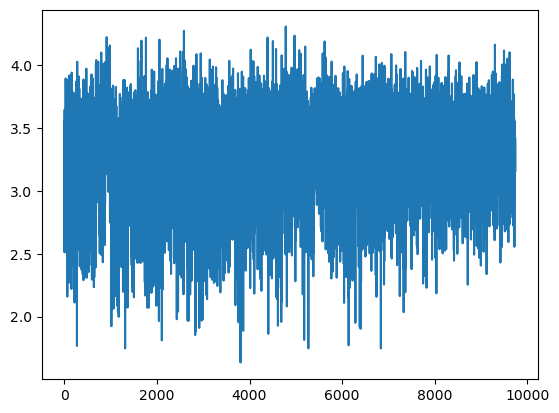

In [322]:
plt.plot(new_ratings)

In [331]:
df_ratings_new = df_ratings.merge(df_genres,left_on='movieId',right_index=True)

In [332]:
df_ratings_new

,userId,movieId,rating,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1,4.0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
516,5,1,4.0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
874,7,1,4.5,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1434,15,1,2.5,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1667,17,1,4.5,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99945,610,6095,3.5,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
100012,610,7202,3.0,0,0,1,1,1,1,0,...,0,0,0,0,0,0,1,0,0,0
100033,610,7562,2.5,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,1,0,0
100038,610,7984,4.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [357]:
user = df_ratings_new[df_ratings_new['userId'] == 1]

In [355]:
for i in list(user.columns[3:]):
    user[i] = user[i]*user['rating']
    user[i].replace({0.0: ''})

/var/folders/33/b9z3l98x2r3fz5kyh065tz7c0000gn/T/ipykernel_52824/936836767.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user[i] = user[i]*user['rating']


In [362]:
user[user['Animation'] == 1]['rating'].mean()

4.4

In [368]:
user['rating'].dot(user['Animation'])/user['Animation'].sum()

4.4

In [ ]:
df_user_genres = df_ratings_new.groupby('userId').mean().drop(columns='movieId')
df_user_genres.iloc[:,1:] = 0

In [396]:
for user in np.arange(1,610):
    df_user = df_ratings_new[df_ratings_new['userId'] == user]
    for c in list(df_genres.columns):
        if(df_user[c].sum() > 0):
            df_user_genres.loc[user,c] = df_user['rating'].dot(df_user[c])/df_user[c].sum() - df_user['rating'].mean()
        else:
            df_user_genres.loc[user,c] = 0

In [397]:
df_user_genres

,rating,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
userId,,,,,,,,,,,,,,,,,,,,,
1,4.366379,0.0,-0.069082,-0.292305,0.033621,-0.033046,0.002851,0.095159,-0.199713,0.026144,...,0.300287,-0.033046,0.000000,-0.116379,0.419335,0.058621,-0.072262,-0.060257,0.033621,-1.366379
2,3.833333,0.0,-0.166667,0.000000,0.000000,0.000000,-0.583333,0.166667,0.000000,0.166667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667,0.000000,0.166667,0.000000,0.000000
3,2.361111,0.0,-0.218254,-0.861111,0.138889,-0.527778,0.888889,0.263889,2.638889,0.312802,...,0.000000,-0.861111,0.138889,0.000000,0.138889,-0.961111,-0.761111,0.076389,1.638889,0.000000
4,3.555556,0.0,-0.273504,-0.412698,-1.355556,-1.388889,0.111111,-0.055556,0.694444,0.098990,...,1.111111,0.319444,0.000000,0.044444,-0.055556,0.252955,-0.555556,-0.379085,0.444444,0.844444
5,3.636364,0.0,0.055944,-0.136364,0.696970,0.163636,-0.064935,-0.136364,0.363636,-0.283422,...,0.000000,0.613636,0.000000,-0.636364,0.363636,0.363636,0.863636,-0.036364,0.000000,-0.636364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,3.667553,0.0,0.069426,0.029726,-0.010690,0.107809,0.024290,0.033340,-0.061493,-0.007598,...,-0.317553,-0.038340,-0.105053,0.018161,0.092062,0.030433,0.020566,0.035572,0.039764,-0.028664
607,3.786096,0.0,0.252365,0.005570,0.547237,0.338904,-0.024191,0.047237,0.613904,-0.123175,...,0.213904,0.213904,0.000000,0.356761,-0.386096,-0.221994,0.367750,-0.178953,-0.119430,-0.036096
608,3.099624,0.0,-0.024624,-0.183782,-0.007519,0.000376,0.058958,0.073845,-0.186581,-0.021818,...,0.614662,-0.004386,0.600376,-0.252402,0.161246,-0.032164,0.243749,0.040503,-0.054170,-0.215009


In [514]:
# for a given user, get predictions for all movies
list_ratings = []
list_preds = []
list_modelPreds = []

for u in np.arange(1,611):
    
    df_user = df_ratings_new[df_ratings_new['userId'] == user].sort_values(by='movieId',ascending=True)
    
    df_genres_user = df_genres.copy()
    df_genres_user = df_genres_user.multiply(df_user_genres.loc[user,:].iloc[1:])
    df_genres_user['sum'] = df_genres_user.mean(axis=1)
    df_genres_user['movieId'] = df_movies['movieId']
    df_genres_user['model rating'] = df_genres_user['movieId'].apply(lambda x: model.predict(user,x)[3])
    df_genres_user['content rating'] = df_genres_user['model rating']-df_genres_user['sum']
    df_genres_user = df_genres_user.sort_values(by='movieId',ascending=True)
    
    df_user_sub = df_user.loc[:,['movieId','rating']]
    df_user_sub = df_user_sub.merge(right=df_genres_user,left_on='movieId',right_on='movieId')
    
    list_ratings.append(df_user_sub['rating'])
    list_preds.append(df_user_sub['content rating'])
    list_modelPreds.append(df_user_sub['model rating'])

In [515]:
np.sqrt(np.sum((np.array(list_ratings)-np.array(list_preds))**2)/df_ratings.shape[0])

0.2990163420202495

In [516]:
np.sqrt(np.sum((np.array(list_ratings)-np.array(list_modelPreds))**2)/df_ratings.shape[0])

0.30089559855338427